# SETUP

## Imports

In [1]:
import base64
import io
import os
import re
import time
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nltk
import numpy as np
import pandas as pd
import requests
import torch
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from googleapiclient.discovery import build
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textwrap import fill

In [2]:
# get .env keys
load_dotenv()
API_KEY = os.getenv("API_KEY")
CSE_ID = os.getenv("CSE_ID")

## Ollama

In [3]:
# check for Ollama instance
for i in range(30):
    try:
        r = requests.get("http://localhost:11434/api/tags", timeout=1)
        if r.status_code == 200:
            print("Ollama served at http://localhost:11434/")
            break
    except Exception:
        time.sleep(1)
else:
    raise RuntimeError("Ollama failed to start.")

Ollama served at http://localhost:11434/


# CLAIM PROCESSING


In [4]:
# download nltk resources
NLTK_DATA_DIR = os.path.join(os.getcwd(), "cache/nltk_data")
os.makedirs(NLTK_DATA_DIR, exist_ok=True)
nltk.data.path.append(NLTK_DATA_DIR)
nltk.download("punkt", quiet=True, download_dir=NLTK_DATA_DIR)
nltk.download("punkt_tab", quiet=True, download_dir=NLTK_DATA_DIR)
nltk.download("stopwords", quiet=True, download_dir=NLTK_DATA_DIR)
nltk.download("wordnet", quiet=True, download_dir=NLTK_DATA_DIR)

True

## Text Processing

In [5]:
def make_query(claim: str) -> str:
    """
    Apply basic preprocessing to convert a claim into a keyword-based search query.
    """
    print(f"Generating query from text: '{claim}'")

    # normalization
    text = claim.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # tokenization
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    lemmas = list(dict.fromkeys(lemmas))

    query = " ".join(lemmas)
    return query

## Image Processing

In [6]:
def caption(image_path: str, text_claim: Optional[str], model: str):
    """
    Generate descriptive text claims from an image claim. If text claim already exists, add more context from image.
    """
    print(f"Generating query from image: '{image_path}'")

    with open(image_path, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode("utf-8")

    # text claim found: supply more context
    if text_claim.strip():
        prompt = f"""
        From the provided image, add more context to the statement to be fact-checked.
        Keep the statement concise and optimal as a search query.
        Respond only with the new statement as plain text.
        Statement: {text_claim}
        """

    # text claim empty: create new text claim
    else:
        prompt = f"""
        From the provided image, extract the statements to be fact-checked.
        Keep the statement concise and optimal as a search query.
        Respond only with the statement as plain text.
        """

    response = requests.post(
        "http://localhost:11434/api/generate",
        json={"model": model, "prompt": prompt, "images": [image_b64], "stream": False},
    )

    return response.json().get("response", "").strip()

# RETRIEVAL

In [7]:
def search(query: str, num_results: int) -> list[str]:
    """
    Retrieve URLs using Google Custom Search API.
    Return a list of string URLs.
    """
    print(f"Searching with query: '{query}'")

    service = build("customsearch", "v1", developerKey=API_KEY)
    res = service.cse().list(q=query, cx=CSE_ID, num=num_results).execute()
    urls = []
    for item in res.get("items", []):
        urls.append(item["link"])

    print(f"Found {len(urls)} URLs")
    return urls

In [8]:
def fetch_text(url: str) -> str:
    """
    Fetch article text from a given URL.
    Return the string body text from the HTML content.
    """
    print(f"Fetching article with URL: {url}")
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        if r.status_code != 200:
            print(f"    Failed to fetch: ({r.status_code})")
            return ""
        soup = BeautifulSoup(r.text, "html.parser")
        ps = soup.select("article p, .entry-content p, p")
        text = " ".join(p.get_text(strip=True) for p in ps)
        return text if text.strip() else ""
    except Exception as e:
        print(f"    Error while fetching: {e}")
        return ""

In [9]:
def retrieve(urls: list[str]) -> list[tuple[str, str]]:
    """
    Retrieve documents from search results based on a query.
    Return list of (url, text) tuples.
    """
    documents = []
    for url in urls:
        document_text = fetch_text(url)
        if document_text.strip():
            documents.append((url, document_text))

    print(f"Successfully retrieved {len(documents)} documents.\n")
    return documents

# EMBEDDING AND RERANKING



## Embedding

In [10]:
def embed(
    query: str, documents: list[tuple[str, str]], model_name: str
) -> tuple[torch.Tensor, torch.Tensor, list[str], list[str]]:
    """
    Generate embeddings for a query and a list of documents using Ollama.
    Return query_embeddings, document_embeddings, urls, document_texts
    """
    if not documents:
        raise RuntimeError("No documents provided for embedding.")

    print(f"Embedding {len(documents)} documents...")

    # helper function
    def ollama_embed(text: str):
        try:
            res = requests.post(
                "http://localhost:11434/api/embeddings",
                json={"model": model_name, "prompt": text},
            )
            data = res.json()
            return data.get("embedding", [])
        except Exception as e:
            print(f"    Error getting embedding: {e}")
            return []

    # query embedding
    print("Generating query embedding...")
    query_vec = ollama_embed(query)
    if not query_vec:
        raise RuntimeError("Query embedding failed.")

    expected_dim = len(query_vec)
    print(f"Query embedding dimension: {expected_dim}")

    # document embeddings
    doc_vecs = []
    valid_urls = []
    valid_texts = []

    for url, text in documents:
        print(f"Embedding document with URL: {url}")
        vec = ollama_embed(text)
        if not vec:
            print(f"    WARNING: Empty embedding for document. Skipping")
            continue
        if len(vec) != expected_dim:
            print(f"    WARNING: Embedding dimension mismatch ({len(vec)} vs {expected_dim}). Skipping.")
            continue
        doc_vecs.append(vec)
        valid_urls.append(url)
        valid_texts.append(text)

    if not doc_vecs:
        raise RuntimeError("No valid document embeddings generated.")
    print(f"Successfully embedded {len(doc_vecs)} documents.\n")

    query_embeddings = torch.tensor(np.array([query_vec]), dtype=torch.float32)
    document_embeddings = torch.tensor(np.array(doc_vecs), dtype=torch.float32)

    return query_embeddings, document_embeddings, valid_urls, valid_texts

## Reranking

In [11]:
def rerank(
    query_embeddings: Optional[torch.Tensor],
    document_embeddings: Optional[torch.Tensor],
    urls: list[str],
    document_texts: list[str],
    top_k: int = 3,
) -> list[tuple[str, str, float]]:
    """
    Rerank precomputed embeddings using cosine similarity.
    Return a list of (url, text, score) tuples sorted by relevance score.
    """
    if query_embeddings is None or document_embeddings is None:
        raise RuntimeError("Query or document embeddings not found.")
    print(f"Reranking {len(document_texts)} documents...")

    query_norm = query_embeddings / query_embeddings.norm(dim=1, keepdim=True)
    doc_norms = document_embeddings / document_embeddings.norm(dim=1, keepdim=True)

    scores = torch.mm(query_norm, doc_norms.T)[0].cpu().numpy()

    ranked = list(zip(urls, document_texts, scores))
    ranked.sort(key=lambda x: x[2], reverse=True)

    return ranked[:top_k]

# PREMISE GENERATION

In [12]:
def generate_premise(claim: str, documents: list[str], model: str):
    """
    Summarize the evidence retrieved for a claim into a short premise.
    """
    joined_documents = "\n".join([f"- {document}" for document in documents])

    prompt = f"""
    Claim: "{claim}"

    Documents:
    {joined_documents}

    From the fact-checking articles, extract the evidences that determine if the claim is fact or misinformation.
    Do not include the claim or unrelated information in your response.
    Provide only the summary of the facts as plain text.
    """

    response = requests.post(
        "http://localhost:11434/api/generate",
        json={"model": model, "prompt": prompt, "stream": False},
    )

    return response.json().get("response", "").strip()

# PIPELINE

In [13]:
def pipeline(text_claim: str, image_path: Optional[str]) -> list[tuple[str, str, float]]:
    """
    Complete IR pipeline: retrieve, rerank, and return top documents.
    Return a list of (url, text, score) tuples for top_k most relevant documents.
    """
    # parameters
    ollama_emb_name = "qwen3-embedding:0.6b"
    ollama_llm_name = "qwen3:4b"
    ollama_vlm_name = "qwen2.5vl:3b"
    num_results = 5
    top_k = 3

    # preprocessing
    if image_path:
        image_claim = caption(image_path, text_claim, ollama_vlm_name)
        query = make_query(image_claim)
        if not text_claim.strip():
            text_claim = image_claim # if image only, use response as text claim
    else:
        query = make_query(text_claim)

    # retrieval
    urls = search(query, num_results)
    documents = retrieve(urls)
    if not documents:
        premise = "No documents related to the claim were found."
        return premise

    # embedding
    claim_embeddings, document_embeddings, urls, document_texts = embed(text_claim, documents, ollama_emb_name)

    # reranking
    best_docs = rerank(claim_embeddings, document_embeddings, urls, document_texts, top_k)
    for url, text, score in best_docs:
        print(f"{url}\nScore: {score:.3f}\nText: {text[0:500]}\n")

    # premise generation
    premise = generate_premise(text_claim, best_docs, ollama_llm_name)
    return premise

## Test Claim

**Notes**

*   Claims in English are processed better than claims in Filipino. Seek more robust (maybe multilingual-LLM-based) solutions as a possible optimization step.

*   With limited testing, decomposing claims into multiple subclaims have yet to prove useful. It multiplies the processing time (2-5x), but Google SEO seems to be powerful enough with just one query.
   
*   Better reranking scores (~20%) when using multilingual embedding models for claims/documents in Filipino. Multilingual models allow for shared embedding spaces across languages, e.g. mixed English/Filipino documents.

In [14]:
def display(claim, image_path, premise):
    img = mpimg.imread(image_path)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    title_y = 1.05

    ax1.axis("off")
    ax1.set_title("Claim", fontsize=14, fontweight="bold", y=title_y)
    ax1.text(
        0.5, 1.00,
        fill(claim, width=50),
        ha="center", va="top", fontsize=12, wrap=True, transform=ax1.transAxes
    )
    ax1.imshow(
        img,
        extent=[0.1, 0.9, 0.1, 0.9],
        transform=ax1.transAxes,
        aspect='auto'
    )

    ax2.axis("off")
    ax2.set_title("Premise", fontsize=14, fontweight="bold", y=title_y)
    ax2.text(
        0.5, 1.00,
        fill(premise, width=50),
        ha="center", va="top", fontsize=12, wrap=True, transform=ax2.transAxes
    )

    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.3, top=0.85, bottom=0.15)
    plt.show()


In [15]:
# image only claim
claim = ""
image_path = "./datasets/documents/1.png"
link = "https://www.factrakers.org/post/vico-sotto-atasha-muhlach-pregnancy-hoax-resurfaces"

print("\nProcessing claim...\n")
premise = pipeline(claim, image_path)
print("\nFinished processing!\n")


Processing claim...

Generating query from image: './datasets/documents/1.png'
Generating query from text: 'Aga Muhlach has accepted Atasha Muhlach's pregnancy with Vico Sotto'
Searching with query: 'aga muhlach accepted atasha pregnancy vico sotto'
Found 5 URLs
Fetching article with URL: https://interaksyon.philstar.com/rumor-cop/2025/05/26/296882/fact-check-vico-sotto-atasha-muhlach-pregnancy-hoax-resurfaces/
Fetching article with URL: https://interaksyon.philstar.com/celebrities/2022/09/06/227243/what-le-bal-said-after-inviting-atasha-muhlach-to-paris-debutante-ball/
Fetching article with URL: https://interaksyon.philstar.com/celebrities/2022/11/28/235995/pinoy-pride-heart-evangelista-cheers-atasha-muhlach-for-representing-ph-in-paris-ball/
Fetching article with URL: https://www.factrakers.org/post/voting-for-certain-partylists-won-t-yield-triple-votes-for-robredo
Fetching article with URL: https://www.factrakers.org/post/marcoleta-not-appointed-doj-secretary
Successfully retrieved

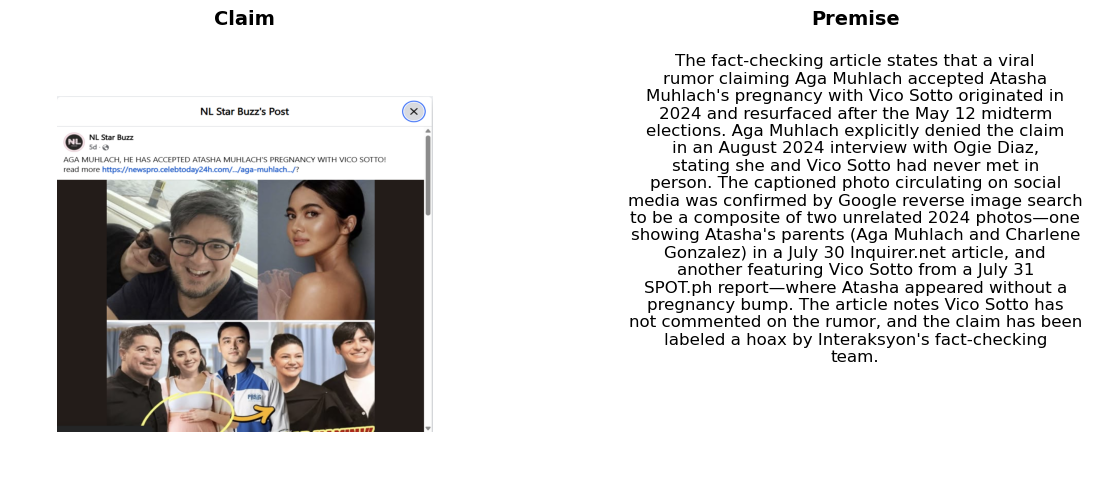

In [16]:
display(claim, image_path, premise)

In [17]:
# text and image claim
claim = "Leni Robredo is pictured using shabu"
image_path = "./datasets/documents/4.png"
link = "https://www.factrakers.org/post/netizen-posts-manipulated-photo-of-robredo-with-bloodshot-eyes"

print("\nProcessing claim...\n")
premise = pipeline(claim, image_path)
print("\nFinished processing!\n")


Processing claim...

Generating query from image: './datasets/documents/4.png'
Generating query from text: 'Is the image of Leni Robredo using shabu correct?'
Searching with query: 'image leni robredo using shabu correct'
Found 5 URLs
Fetching article with URL: https://www.factrakers.org/post/netizen-posts-manipulated-photo-of-robredo-with-bloodshot-eyes
Fetching article with URL: https://verafiles.org/articles/vera-files-fact-check-netizen-recycles-fake-story-claiming-n
Fetching article with URL: https://www.factrakers.org/post/fb-page-revives-robredo-misquote-to-decriminalize-drugs
Fetching article with URL: https://verafiles.org/articles/vera-files-fact-check-panelo-negates-duterte-now-says-robred
Fetching article with URL: https://www.rappler.com/plus-membership-program/exclusive-content/robredo-18-days-as-drug-czar/
Successfully retrieved 5 documents.

Embedding 5 documents...
Generating query embedding...
Query embedding dimension: 1024
Embedding document with URL: https://www.f

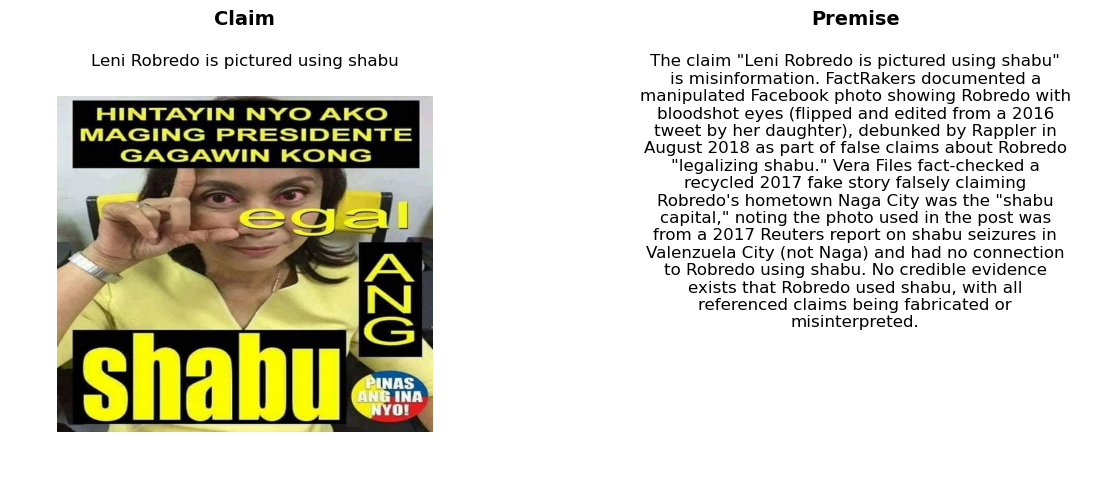

In [18]:
display(claim, image_path, premise)